#Libraries

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
!pip install catboost
import catboost
from catboost import CatBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
!pip install lightgbm
import lightgbm
%matplotlib inline
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from sklearn.model_selection import StratifiedKFold
from scipy.sparse import hstack
from scipy.sparse import csr_matrix
warnings.filterwarnings("ignore")
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization,Input,PReLU
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.models import Model
from keras.optimizers import Adagrad

     |████████████████████████████████| 67.3MB 53kB/s 


In [ ]:
 from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


REFERENCE:

https://www.kaggle.com/c/talkingdata-mobile-user-demographics/discussion/23424

https://www.kaggle.com/dvasyukova/a-linear-model-on-apps-and-labels

https://github.com/chechir/talking_data

#**Preprocessing:**

In [ ]:
datadir = '/content/drive/MyDrive/Talkingdata_CS1/talkingdata-mobile-user-demographics/data/'
gender_age_train = pd.read_csv(os.path.join(datadir,'gender_age_train.csv'),index_col='device_id')
gender_age_test = pd.read_csv(os.path.join(datadir,'gender_age_test.csv'),index_col = 'device_id')
phone_brand_device_model = pd.read_csv(os.path.join(datadir,'phone_brand_device_model.csv'))
#removing duplicates in phone_brand_device_model
phone_brand_device_model = phone_brand_device_model.drop_duplicates('device_id',keep='first').set_index('device_id')
events_data = pd.read_csv(os.path.join(datadir,'events.csv'),parse_dates=['timestamp'], index_col='event_id')
apps_events_data = pd.read_csv(os.path.join(datadir,'app_events.csv'), usecols=['event_id','app_id','is_active'],dtype={'is_active':bool})
apps_label_data = pd.read_csv(os.path.join(datadir,'app_labels.csv'))
#print('Features for all the data irrespective of events')
#BOW for Phone Brand:
gender_age_test['testrow'] = np.arange(gender_age_test.shape[0])
gender_age_train['trainrow'] = np.arange(gender_age_train.shape[0])     
from sklearn.preprocessing import LabelEncoder
y_encoder=LabelEncoder().fit(gender_age_train.group)
Ytrain_all =y_encoder.transform(gender_age_train.group)

#ref:https://www.kaggle.com/dvasyukova/a-linear-model-on-apps-and-labels
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix, hstack
brand_encoder = LabelEncoder().fit(phone_brand_device_model.phone_brand)
phone_brand_device_model['brand'] = brand_encoder.transform(phone_brand_device_model['phone_brand'])
gender_age_test['brand'] = phone_brand_device_model['brand']
gender_age_train['brand'] = phone_brand_device_model['brand']
gender_age_test['brand']=gender_age_test['brand'].astype(int) 
gender_age_train['brand']=gender_age_train['brand'].astype(int) 
Xtr_brand = csr_matrix((np.ones(gender_age_train.shape[0]),(gender_age_train.trainrow, gender_age_train.brand)))
Xte_brand = csr_matrix((np.ones(gender_age_test.shape[0]),(gender_age_test.testrow, gender_age_test.brand)))
#print('Phone_Brand features train:',Xtr_brand.shape, 'test shape:' ,Xte_brand.shape)

#BOW for Phone Model
model_brand = phone_brand_device_model.phone_brand.str.cat(phone_brand_device_model.device_model)
modelencoder = LabelEncoder().fit(model_brand)
phone_brand_device_model['model'] = modelencoder.transform(model_brand)
gender_age_train['model'] = phone_brand_device_model['model']
gender_age_test['model'] = phone_brand_device_model['model']
Xtr_model = csr_matrix((np.ones(gender_age_train.shape[0]), (gender_age_train.trainrow, gender_age_train.model)))
Xte_model = csr_matrix((np.ones(gender_age_test.shape[0]), (gender_age_test.testrow, gender_age_test.model)))

#TRAIN AND TEST FOR ALL DATA
Xtrain_all = hstack((Xtr_brand, Xtr_model), format='csr')
Xtest_all =  hstack((Xte_brand, Xte_model), format='csr')
print('All Data features irrespective of events: train shape:',Xtrain_all.shape, 'test shape:' ,Xtest_all.shape)


#Splitting the data into data with events and data without events and extracting features from it
#Reloading Train & Test data and splitting them to data with and without events
gender_age_train = pd.read_csv(os.path.join(datadir,'gender_age_train.csv'))
gender_age_test = pd.read_csv(os.path.join(datadir,'gender_age_test.csv'))
device_id_has_events=events_data.device_id.unique() 
gender_age_train['has_events']=gender_age_train.device_id.apply(lambda x:1 if x in device_id_has_events else 0)  
gender_age_test['has_events']=gender_age_test.device_id.apply(lambda x:1 if x in device_id_has_events else 0)  


gatrain_has_events=gender_age_train.loc[gender_age_train['has_events']==1].drop(['age','gender','has_events'],axis=1).set_index('device_id')
gatrain_has_noevents=gender_age_train.loc[gender_age_train['has_events']==0].drop(['age','gender','has_events'],axis=1).set_index('device_id')
gatest_has_events=gender_age_test.loc[gender_age_test['has_events']==1].drop(['has_events'],axis=1).set_index('device_id')
gatest_has_noevents=gender_age_test.loc[gender_age_test['has_events']==0].drop(['has_events'],axis=1).set_index('device_id')
gender_age_train=gender_age_train.set_index('device_id')
gender_age_test=gender_age_test.set_index('device_id')

gender_age_train['trainrow']=np.arange(gender_age_train.shape[0])
gender_age_test['testrow']=np.arange(gender_age_test.shape[0])
gatrain_has_events['trainrow']=np.arange(gatrain_has_events.shape[0])
gatest_has_events['testrow']=np.arange(gatest_has_events.shape[0])
gatrain_has_noevents['trainrow']=np.arange(gatrain_has_noevents.shape[0])
gatest_has_noevents['testrow']=np.arange(gatest_has_noevents.shape[0])

y_encoder_ev=LabelEncoder().fit(gatrain_has_events.group)
Ytrain_events =y_encoder_ev.transform(gatrain_has_events.group)

y_encoder_noev=LabelEncoder().fit(gatrain_has_noevents.group)
Ytrain_noevents =y_encoder_noev.transform(gatrain_has_noevents.group)


#BOW of Brands
brand_encoder = LabelEncoder().fit(phone_brand_device_model['phone_brand'])
phone_brand_device_model['brand'] = brand_encoder.transform(phone_brand_device_model['phone_brand'])
nbrands=len(brand_encoder.classes_)
#BOW of Models
model_brand = phone_brand_device_model['phone_brand'].str.cat(phone_brand_device_model['device_model'])
model_encoder=LabelEncoder().fit(model_brand)
phone_brand_device_model['model_brand']=model_encoder.transform(model_brand)
nmodels=len(model_encoder.classes_)


#Features for  events
gatrain_has_noevents['phone_brand']=phone_brand_device_model['brand']
gatest_has_noevents['phone_brand']=phone_brand_device_model['brand']
Xtr_brand = csr_matrix((np.ones(gatrain_has_noevents.shape[0]), (gatrain_has_noevents.trainrow, gatrain_has_noevents.phone_brand)), shape=(gatrain_has_noevents.shape[0],nbrands))
Xte_brand = csr_matrix((np.ones(gatest_has_noevents.shape[0]), (gatest_has_noevents.testrow, gatest_has_noevents.phone_brand)), shape=(gatest_has_noevents.shape[0],nbrands))
#print('Phone Model features: train shape:',Xtr_brand.shape, 'test shape:' ,Xte_brand.shape)

gatrain_has_noevents['phone_model']=phone_brand_device_model['model_brand']
gatest_has_noevents['phone_model']=phone_brand_device_model['model_brand']
Xtr_model = csr_matrix((np.ones(gatrain_has_noevents.shape[0]), (gatrain_has_noevents.trainrow, gatrain_has_noevents.phone_model)), shape=(gatrain_has_noevents.shape[0],nmodels))
Xte_model = csr_matrix((np.ones(gatest_has_noevents.shape[0]), (gatest_has_noevents.testrow, gatest_has_noevents.phone_model)), shape=(gatest_has_noevents.shape[0],nmodels))
#print('Phone Model features: train shape:',Xtr_model.shape, 'test shape:' ,Xte_model.shape)

Xtrain_noevents = hstack((Xtr_brand, Xtr_model), format='csr')
Xtest_noevents =  hstack((Xte_brand, Xte_model), format='csr')
print('Data with Noevents features: train shape:',Xtrain_noevents.shape, 'test shape:' ,Xtest_noevents.shape)

#Features for Data with events

#BOW for brands
gatrain_has_events['phone_brand']=phone_brand_device_model['brand']
gatest_has_events['phone_brand']=phone_brand_device_model['brand']
Xtr_brand= csr_matrix((np.ones(gatrain_has_events.shape[0]), (gatrain_has_events.trainrow, gatrain_has_events.phone_brand)), shape=(gatrain_has_events.shape[0],nbrands))
Xte_brand = csr_matrix((np.ones(gatest_has_events.shape[0]), (gatest_has_events.testrow, gatest_has_events.phone_brand)), shape=(gatest_has_events.shape[0],nbrands))
#print('Phone Model features: train shape:',Xtr_brand.shape, 'test shape:' ,Xte_brand.shape)

#BOW for models
gatrain_has_events['phone_model']=phone_brand_device_model['model_brand']
gatest_has_events['phone_model']=phone_brand_device_model['model_brand']
Xtr_model = csr_matrix((np.ones(gatrain_has_events.shape[0]), (gatrain_has_events.trainrow, gatrain_has_events.phone_model)), shape=(gatrain_has_events.shape[0],nmodels))
Xte_model = csr_matrix((np.ones(gatest_has_events.shape[0]), (gatest_has_events.testrow, gatest_has_events.phone_model)), shape=(gatest_has_events.shape[0],nmodels))
#print('Phone Model features: train shape:',Xtr_model.shape, 'test shape:' ,Xte_model.shape)

#BOW for Apps
app_encoder = LabelEncoder().fit(apps_events_data['app_id'])
apps_events_data['app'] = app_encoder.transform(apps_events_data['app_id'])
napps = len(app_encoder.classes_)
device_apps = (apps_events_data.merge(events_data[['device_id']], how='left',left_on='event_id',right_index=True)
                    .groupby(['device_id','app'])['app'].agg(['size'])
                    .merge(gatrain_has_events[['trainrow']], how='left', left_index=True, right_index=True)
                    .merge(gatest_has_events[['testrow']], how='left', left_index=True, right_index=True)
                    .reset_index())

device_apps_train = device_apps.dropna(subset=['trainrow'])
Xtr_app = csr_matrix((np.ones(device_apps_train.shape[0]), (device_apps_train.trainrow, device_apps_train.app)), shape=(gatrain_has_events.shape[0],napps))
device_apps_test = device_apps.dropna(subset=['testrow'])
Xte_app = csr_matrix((np.ones(device_apps_test.shape[0]), (device_apps_test.testrow, device_apps_test.app)), shape=(gatest_has_events.shape[0],napps))
#print('Apps data: train shape:',Xtr_app.shape, 'test shape:' ,Xte_app.shape)

#BOW for Labels
app_labels = apps_label_data.loc[apps_label_data['app_id'].isin(apps_events_data['app_id'].unique())]
app_labels['app'] = app_encoder.transform(app_labels['app_id'])
labelencoder = LabelEncoder().fit(app_labels['label_id'])
app_labels['label'] = labelencoder.transform(app_labels['label_id'])
nlabels = len(labelencoder.classes_)

device_labels = (device_apps[['device_id','app']]
            .merge(app_labels[['app','label']])
            .groupby(['device_id','label'])['app'].agg(['size'])
            .merge(gatrain_has_events[['trainrow']], how='left', left_index=True, right_index=True)
            .merge(gatest_has_events[['testrow']], how='left', left_index=True, right_index=True)
            .reset_index())

device_labels_train = device_labels.dropna(subset=['trainrow'])
Xtr_label = csr_matrix((np.ones(device_labels_train.shape[0]), (device_labels_train.trainrow, device_labels_train.label)), shape=(gatrain_has_events.shape[0],nlabels))
device_labels_test = device_labels.dropna(subset=['testrow'])
Xte_label = csr_matrix((np.ones(device_labels_test.shape[0]), (device_labels_test.testrow, device_labels_test.label)), shape=(gatest_has_events.shape[0],nlabels))
#print('Label data: train shape:',Xtr_app.shape, 'test shape:' ,Xte_app.shape)

#TFIDF for hour feature
events_data['hour'] = events_data.timestamp.dt.hour
event_hours = events_data.groupby("device_id")["hour"].apply(lambda x: " ".join(str(s) for s in x)).to_frame()

event_hours=(event_hours.merge(gatrain_has_events[['trainrow']], how='left', left_index=True, right_index=True)
          .merge(gatest_has_events[['testrow']], how='left', left_index=True, right_index=True)
          .reset_index())

Hour_train = event_hours.dropna(subset=['trainrow'])
Hour_test = event_hours.dropna(subset=['testrow'])

vectorizer=TfidfVectorizer()
vectorizer.fit(Hour_train['hour'].values)

X_tr_event_hours = vectorizer.transform(Hour_train['hour'].values).tocsr()
X_te_event_hours = vectorizer.transform(Hour_test['hour'].values).tocsr()

#TFIDF for day feature
events_data['event_day'] = events_data.timestamp.dt.weekday
Week_of_eventday = (events_data.groupby("device_id")["event_day"].apply(lambda x: " ".join('0'+str(s) for s in x)).to_frame()
                    .merge(gatrain_has_events[['trainrow']], how='left', left_index=True, right_index=True)
                    .merge(gatest_has_events[['testrow']], how='left', left_index=True, right_index=True)
                    .reset_index())

Day_train = Week_of_eventday.dropna(subset=['trainrow'])
Day_test = Week_of_eventday.dropna(subset=['testrow'])

vectorizer=TfidfVectorizer()
vectorizer.fit(Day_train['event_day'].values)

X_tr_event_day = vectorizer.transform(Day_train['event_day'].values).tocsr()
X_te_event_day = vectorizer.transform(Day_test['event_day'].values).tocsr()

#TFIDF for apps active feature

apps_active_data = apps_events_data.groupby("event_id")["is_active"].apply(lambda x: " ".join(str(s) for s in x))
events_data["apps_active"] = events_data.index.map(apps_active_data)
events_apps_active = (events_data.groupby("device_id")["apps_active"].apply(lambda x: " ".join(str(s) for s in x if str(s)!='nan')).to_frame()
                    .merge(gatrain_has_events[['trainrow']], how='left', left_index=True, right_index=True)
                    .merge(gatest_has_events[['testrow']], how='left', left_index=True, right_index=True)
                    .reset_index())
app_event_train = events_apps_active.dropna(subset=['trainrow'])
app_event_test = events_apps_active.dropna(subset=['testrow'])

vectorizer=TfidfVectorizer()
vectorizer.fit(app_event_train['apps_active'].values)

X_tr_apps_active = vectorizer.transform(app_event_train['apps_active'].values).tocsr()
X_te_apps_active = vectorizer.transform(app_event_test['apps_active'].values).tocsr()


#Location median
events_lat_data = (events_data.groupby("device_id")["latitude"].apply(lambda x: np.median([float(s) for s in x])).to_frame()
                    .merge(gatrain_has_events[['trainrow']], how='left', left_index=True, right_index=True)
                    .merge(gatest_has_events[['testrow']], how='left', left_index=True, right_index=True)
                    .reset_index())
events_long_data = (events_data.groupby("device_id")["longitude"].apply(lambda x: np.median([float(s) for s in x])).to_frame()
                    .merge(gatrain_has_events[['trainrow']], how='left', left_index=True, right_index=True)
                    .merge(gatest_has_events[['testrow']], how='left', left_index=True, right_index=True)
                    .reset_index())

lat_events_train=abs(events_lat_data.dropna(subset=['trainrow']))
lat_events_test=abs(events_lat_data.dropna(subset=['testrow']))
long_events_train=abs(events_long_data.dropna(subset=['trainrow']))
long_events_test=abs(events_long_data.dropna(subset=['testrow']))

std_scaler=StandardScaler()
std_scaler.fit(lat_events_train['latitude'].values.reshape(-1,1))
X_tr_event_lat_med = std_scaler.transform(lat_events_train['latitude'].values.reshape(-1,1))
X_te_event_lat_med = std_scaler.transform(lat_events_test['latitude'].values.reshape(-1,1))

std_scaler=StandardScaler()
std_scaler.fit(long_events_train['longitude'].values.reshape(-1,1))
X_tr_event_long_med = std_scaler.transform(long_events_train['longitude'].values.reshape(-1,1))
X_te_event_long_med = std_scaler.transform(long_events_test['longitude'].values.reshape(-1,1))


#location outlier feature:
event_lat_long=events_long_data.merge(events_lat_data[['latitude']], how='left', left_index=True, right_index=True)
outlier_devices=event_lat_long.loc[event_lat_long['latitude']==0.00].loc[event_lat_long['longitude']==0.00]['device_id'].unique()

events_data['missing_location']=events_data.device_id.apply(lambda x:1 if x in outlier_devices else 0) 

loc_outlier = (events_data[['device_id','missing_location']]
                    .merge(gatrain_has_events[['trainrow']], how='left', left_index=True, right_index=True)
                    .merge(gatest_has_events[['testrow']], how='left', left_index=True, right_index=True)
                    .reset_index())

loc_outlier_tr = loc_outlier.dropna(subset=['trainrow'])
Xtr_loc_outlier = csr_matrix((np.ones(loc_outlier_tr.shape[0]), (loc_outlier_tr.trainrow, loc_outlier_tr['missing_location'])),shape=(gatrain_has_events.shape[0],2))

loc_outlier_te = loc_outlier.dropna(subset=['testrow'])
Xte_loc_outlier = csr_matrix((np.ones(loc_outlier_te.shape[0]), (loc_outlier_te.testrow, loc_outlier_te['missing_location'])),shape=(gatest_has_events.shape[0],2))
#print('location_outlier data: train shape:',Xtr_location_outlier.shape, 'test shape:' ,Xte_location_outlier.shape)





Xtrain_events = hstack((Xtr_brand, Xtr_model,Xtr_app,Xtr_label,X_tr_event_hours,X_tr_event_day,X_tr_apps_active,X_tr_event_lat_med,X_tr_event_long_med,Xtr_loc_outlier), format='csr')
Xtest_events =  hstack((Xte_brand, Xte_model,Xte_app,Xte_label,X_te_event_hours,X_te_event_day,X_te_apps_active,X_te_event_lat_med,X_te_event_long_med,Xte_loc_outlier), format='csr')
print('Data with Events features: train shape:',Xtrain_events.shape, 'test shape:' ,Xtest_events.shape)

All Data features irrespective of events: train shape: (74645, 1798) test shape: (112071, 1798)
Data with Noevents features: train shape: (51336, 1798) test shape: (76877, 1798)
Data with Events features: train shape: (23309, 21554) test shape: (35194, 21554)


In [ ]:
import scipy.sparse
from scipy import sparse
#scipy.sparse.save_npz('/content/drive/MyDrive/Talkingdata_CS1/talkingdata-mobile-user-demographics/Xtrain_events.npz', Xtrain_events)
#scipy.sparse.save_npz('/content/drive/MyDrive/Talkingdata_CS1/talkingdata-mobile-user-demographics/Xtrain_noevents.npz', Xtrain_noevents)
#scipy.sparse.save_npz('/content/drive/MyDrive/Talkingdata_CS1/talkingdata-mobile-user-demographics/Xtest_events.npz', Xtest_events)
#scipy.sparse.save_npz('/content/drive/MyDrive/Talkingdata_CS1/talkingdata-mobile-user-demographics/Xtest_noevents.npz', Xtest_noevents)
#scipy.sparse.save_npz('/content/drive/MyDrive/Talkingdata_CS1/talkingdata-mobile-user-demographics/Xtrain_all.npz', Xtrain_all)
#scipy.sparse.save_npz('/content/drive/MyDrive/Talkingdata_CS1/talkingdata-mobile-user-demographics/Xtest_all.npz', Xtest_all)

#Ytrain_events=sparse.csr_matrix(Ytrain_events)
#Ytrain_noevents=sparse.csr_matrix(Ytrain_noevents)
#Ytrain_all=sparse.csr_matrix(Ytrain_all)
#scipy.sparse.save_npz('/content/drive/MyDrive/Talkingdata_CS1/talkingdata-mobile-user-demographics/Ytrain_events.npz', Ytrain_events)
#scipy.sparse.save_npz('/content/drive/MyDrive/Talkingdata_CS1/talkingdata-mobile-user-demographics/Ytrain_noevents.npz', Ytrain_noevents)
#scipy.sparse.save_npz('/content/drive/MyDrive/Talkingdata_CS1/talkingdata-mobile-user-demographics/Ytrain_all.npz', Ytrain_all)

#Loading

In [ ]:
import scipy.sparse
from scipy import sparse

Xtrain_events=scipy.sparse.load_npz('/content/drive/MyDrive/Talkingdata_CS1/talkingdata-mobile-user-demographics/Xtrain_events.npz')
Xtrain_noevents=scipy.sparse.load_npz('/content/drive/MyDrive/Talkingdata_CS1/talkingdata-mobile-user-demographics/Xtrain_noevents.npz')
Xtest_events=scipy.sparse.load_npz('/content/drive/MyDrive/Talkingdata_CS1/talkingdata-mobile-user-demographics/Xtest_events.npz')
Xtest_noevents=scipy.sparse.load_npz('/content/drive/MyDrive/Talkingdata_CS1/talkingdata-mobile-user-demographics/Xtest_noevents.npz' )
Xtrain_all=scipy.sparse.load_npz('/content/drive/MyDrive/Talkingdata_CS1/talkingdata-mobile-user-demographics/Xtrain_all.npz' )
Xtest_all=scipy.sparse.load_npz('/content/drive/MyDrive/Talkingdata_CS1/talkingdata-mobile-user-demographics/Xtest_all.npz' )

Ytrain_events=scipy.sparse.load_npz('/content/drive/MyDrive/Talkingdata_CS1/talkingdata-mobile-user-demographics/Ytrain_events.npz' )
Ytrain_noevents=scipy.sparse.load_npz('/content/drive/MyDrive/Talkingdata_CS1/talkingdata-mobile-user-demographics/Ytrain_noevents.npz')
Ytrain_all=scipy.sparse.load_npz('/content/drive/MyDrive/Talkingdata_CS1/talkingdata-mobile-user-demographics/Ytrain_all.npz' )
Ytrain_events=sparse.csr_matrix.toarray(Ytrain_events)[0]
Ytrain_noevents=sparse.csr_matrix.toarray(Ytrain_noevents)[0]
Ytrain_all=sparse.csr_matrix.toarray(Ytrain_all)[0]

#Approach:

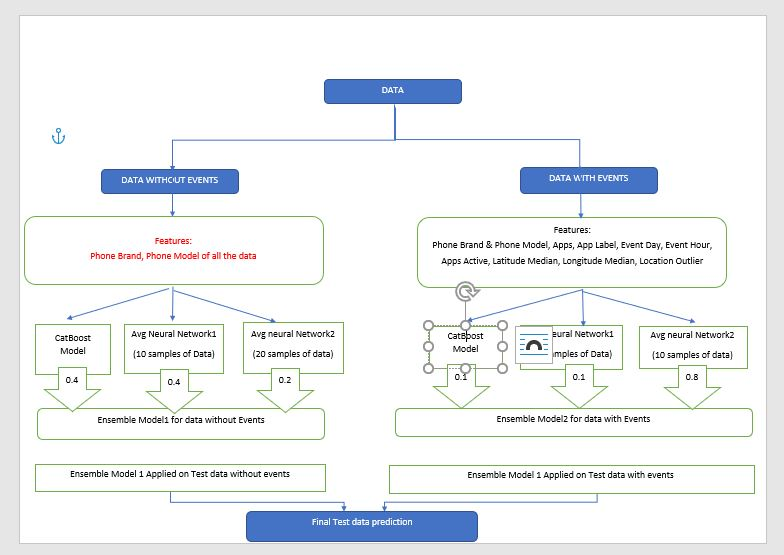

In [ ]:
from IPython.display import Image
Image(filename=('/content/chart_mf.JPG'))

# **Models on Data without Events**

In [ ]:
# train test split
from sklearn.model_selection import train_test_split
x_train, x_cv, y_train, y_cv = train_test_split(Xtrain_all, Ytrain_all, test_size=0.15, stratify=Ytrain_all,random_state=10)

#Appplying LogisticRegression

In [ ]:
#Appplying LogisticRegression:
#Hyper parameter Tuning:
C_values = [0.0001,0.001,0.01,0.1,1,10,100]
log_loss_list_tr = []
log_loss_list_cv = []
for i in C_values:
    clf_lr_noev = LogisticRegression(C=i,random_state=10)
    clf_lr_noev.fit(x_train,y_train)
    log_loss_tr_lr=log_loss(y_train,clf_lr_noev.predict_proba(x_train))
    log_loss_cv_lr=log_loss(y_cv,clf_lr_noev.predict_proba(x_cv))
    log_loss_list_tr.append(log_loss_tr_lr)
    log_loss_list_cv.append(log_loss_cv_lr)
    print('cv log_loss for C=',i,'is',log_loss_cv_lr)

best_C = C_values[np.argmin(log_loss_list_cv)]
clf_lr_noev = LogisticRegression(C=best_C,random_state=10)
clf_lr_noev.fit(x_train,y_train)
y_pred_tr=clf_lr_noev.predict_proba(x_train)
y_pred_cv=clf_lr_noev.predict_proba(x_cv)
log_loss_tr_lr_noev=log_loss(y_train,clf_lr_noev.predict_proba(x_train))
log_loss_cv_lr_noev=log_loss(y_cv,clf_lr_noev.predict_proba(x_cv))
print('\nBest Values -Logistic Regression')
print('\ntrain log_loss for C=',best_C,'is',log_loss_tr_lr_noev)
print('cv log_loss for C=',best_C,'is',log_loss_cv_lr_noev)

cv log_loss for C= 0.0001 is 2.4249213424010136
cv log_loss for C= 0.001 is 2.412113705036659
cv log_loss for C= 0.01 is 2.3976830872132404
cv log_loss for C= 0.1 is 2.390850104144421
cv log_loss for C= 1 is 2.404019112899443
cv log_loss for C= 10 is 2.433499874529464
cv log_loss for C= 100 is 2.4426966181246623

Best Values -Logistic Regression

train log_loss for C= 0.1 is 2.3558331330807096
cv log_loss for C= 0.1 is 2.390850104144421


#Applying Naive Bayes

In [ ]:
#Applying Naive Bayes
#Hyper parameter Tuning:
log_loss_list_tr = []
log_loss_list_cv = []
Alpha_values = [0.01,0.1,1,10,100,1000,10000]
for i in Alpha_values:
    clf_nb_noev = MultinomialNB(alpha=i)
    clf_nb_noev.fit(x_train,y_train)
    log_loss_tr_nb=log_loss(y_train,clf_nb_noev.predict_proba(x_train))
    log_loss_cv_nb=log_loss(y_cv,clf_nb_noev.predict_proba(x_cv))
    log_loss_list_tr.append(log_loss_tr_nb)
    log_loss_list_cv.append(log_loss_cv_nb)
    print('cv log_loss for alpha=',i,'is',log_loss_cv_nb)

best_alpha = Alpha_values[np.argmin(log_loss_list_cv)]
clf_nb_noev = MultinomialNB(alpha=best_alpha)
clf_nb_noev.fit(x_train,y_train)
log_loss_tr_nb_noev=log_loss(y_train,clf_nb_noev.predict_proba(x_train))
log_loss_cv_nb_noev=log_loss(y_cv,clf_nb_noev.predict_proba(x_cv))
print('\nBest Values -Naive Bayes')
print('\ntrain log_loss for alpha=',best_alpha,'is',log_loss_tr_nb_noev)
print('cv log_loss for alpha=',best_alpha,'is',log_loss_cv_nb_noev)

cv log_loss for alpha= 0.01 is 2.594541863660797
cv log_loss for alpha= 0.1 is 2.4942273493766702
cv log_loss for alpha= 1 is 2.4321837917788063
cv log_loss for alpha= 10 is 2.4449004483052534
cv log_loss for alpha= 100 is 2.4520242511543806
cv log_loss for alpha= 1000 is 2.4250394331581977
cv log_loss for alpha= 10000 is 2.4255542022384273

Best Values -Naive Bayes

train log_loss for alpha= 1000 is 2.422916400063427
cv log_loss for alpha= 1000 is 2.4250394331581977


#Applying Decision Tree

Heatmap for log_loss values Train data


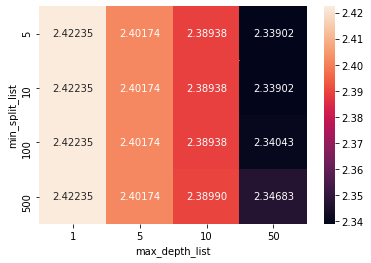


Heatmap for log_loss values CV data


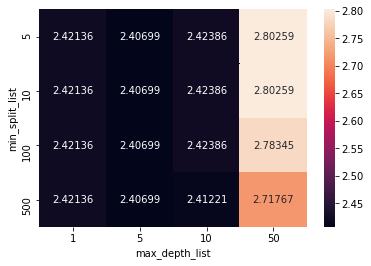


Best Values for Decision Trees

train log_loss for max_depth= 5 ,min_samples_split= 100 is 2.401737796174455
cv log_loss for max_depth= 5 ,min_samples_split= 100 is 2.4069909571046173


In [ ]:
#Applying Decision Tree
#Hyper parameter Tuning:

max_depth_list=[1, 5, 10, 50]
min_split_list=[5, 10, 100, 500]
log_loss_list_tr = []
log_loss_list_cv = []
for i in min_split_list:
  for j in max_depth_list:
    clf_dt_noev = DecisionTreeClassifier(max_depth=j,min_samples_split=i,random_state=10)
    clf_dt_noev.fit(x_train,y_train)
    y_pred_tr=clf_dt_noev.predict_proba(x_train)
    y_pred_cv=clf_dt_noev.predict_proba(x_cv)
    log_loss_tr_dt=log_loss(y_train,y_pred_tr)
    log_loss_cv_dt=log_loss(y_cv,y_pred_cv)
    log_loss_list_tr.append(log_loss_tr_dt)
    log_loss_list_cv.append(log_loss_cv_dt)


#representing Log_Loss values in HEat Maps
sbn_log_loss_tr=np.reshape(log_loss_list_tr,(4,4))
sbn_log_loss_cv=np.reshape(log_loss_list_cv,(4,4))
import seaborn as sns
xticks=[1,5,10,50]
yticks=[5, 10, 100, 500]

print('Heatmap for log_loss values Train data')
heat_map_cv = sns.heatmap(sbn_log_loss_tr, annot=True,yticklabels=yticks,xticklabels=xticks,fmt='.5f')
plt.xlabel('max_depth_list')
plt.ylabel('min_split_list')
plt.show()

print('\nHeatmap for log_loss values CV data')
heat_map_cv = sns.heatmap(sbn_log_loss_cv, annot=True,yticklabels=yticks,xticklabels=xticks,fmt='.5f')
plt.xlabel('max_depth_list')
plt.ylabel('min_split_list')
plt.show()


best_max_depth=5
best_min_samples_split=100

clf_dt_noev = DecisionTreeClassifier(max_depth=best_max_depth,min_samples_split=best_min_samples_split,random_state=10)
clf_dt_noev.fit(x_train,y_train)
y_pred_tr=clf_dt_noev.predict_proba(x_train)
y_pred_cv=clf_dt_noev.predict_proba(x_cv)
log_loss_tr_dt_noev=log_loss(y_train,y_pred_tr)
log_loss_cv_dt_noev=log_loss(y_cv,y_pred_cv)
print('\nBest Values for Decision Trees')
print('\ntrain log_loss for max_depth=',best_max_depth,',min_samples_split=',best_min_samples_split,'is',log_loss_tr_dt_noev)
print('cv log_loss for max_depth=',best_max_depth,',min_samples_split=',best_min_samples_split,'is',log_loss_cv_dt_noev)

#Applying Random Forest Classifier


Heatmap for log_loss values Train data


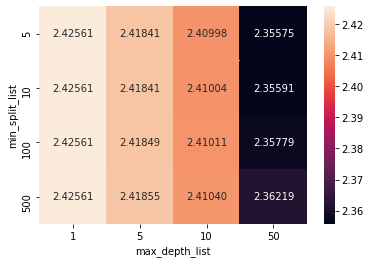


Heatmap for log_loss values CV data


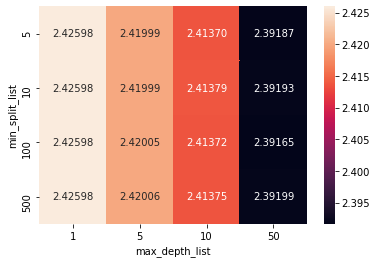

Best Values-Random Forest:

train log_loss for max_depth= 50 ,min_samples_split= 100 is 2.3577910059503533
cv log_loss for max_depth= 50 ,min_samples_split= 100 is 2.391646384699301


In [ ]:

from sklearn.ensemble import RandomForestClassifier
log_loss_list_tr = []
log_loss_list_cv = []
#Hyper parameter Tuning:

max_depth_list=[1, 5, 10, 50]
min_split_list=[5, 10, 100, 500]
for i in min_split_list:
  for j in max_depth_list:
    clf_rf_noev = RandomForestClassifier(max_depth=j,min_samples_split=i,random_state=10)
    clf_rf_noev.fit(x_train,y_train)
    y_pred_tr=clf_rf_noev.predict_proba(x_train)
    y_pred_cv=clf_rf_noev.predict_proba(x_cv)
    log_loss_tr_rf=log_loss(y_train,y_pred_tr)
    log_loss_cv_rf=log_loss(y_cv,y_pred_cv)
    log_loss_list_tr.append(log_loss_tr_rf)
    log_loss_list_cv.append(log_loss_cv_rf)

#representing Log_Loss values in HEat Maps
sbn_log_loss_tr=np.reshape(log_loss_list_tr,(4,4))
sbn_log_loss_cv=np.reshape(log_loss_list_cv,(4,4))
import seaborn as sns
xticks=[1,5,10,50]
yticks=[5, 10, 100, 500]

print('\nHeatmap for log_loss values Train data')
heat_map_cv = sns.heatmap(sbn_log_loss_tr, annot=True,yticklabels=yticks,xticklabels=xticks,fmt='.5f')
plt.xlabel('max_depth_list')
plt.ylabel('min_split_list')
plt.show()

print('\nHeatmap for log_loss values CV data')
heat_map_cv = sns.heatmap(sbn_log_loss_cv, annot=True,yticklabels=yticks,xticklabels=xticks,fmt='.5f')
plt.xlabel('max_depth_list')
plt.ylabel('min_split_list')
plt.show()

best_max_depth=50
best_min_samples_split=100

clf_rf_noev = RandomForestClassifier(max_depth=best_max_depth,min_samples_split=best_min_samples_split,random_state=10)
clf_rf_noev.fit(x_train,y_train)
y_pred_tr=clf_rf_noev.predict_proba(x_train)
y_pred_cv=clf_rf_noev.predict_proba(x_cv)
log_loss_tr_rf_noev=log_loss(y_train,y_pred_tr)
log_loss_cv_rf_noev=log_loss(y_cv,y_pred_cv)
print('Best Values-Random Forest:')
print('\ntrain log_loss for max_depth=',best_max_depth,',min_samples_split=',best_min_samples_split,'is',log_loss_tr_rf_noev)
print('cv log_loss for max_depth=',best_max_depth,',min_samples_split=',best_min_samples_split,'is',log_loss_cv_rf_noev)


#Applying LGBM Classifier

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from lightgbm import LGBMClassifier

log_loss_list_tr = []
log_loss_list_cv = []
#Hyper parameter Tuning:
n_est=[10,50,100,350,400,500]
for i in n_est:
    #clf=CatBoostClassifier(n_estimators=i,learning_rate=0.05, colsample_bytree=0.7, max_depth=5,subsample=0.7,objective='multi:softprob',num_class=12,eval_metric='mlogloss')
    clf=LGBMClassifier(verbose=0, n_estimators=i,random_state=10)
    clf.fit(x_train, y_train)
    y_pred_tr=clf.predict_proba(x_train)
    y_pred_cv=clf.predict_proba(x_cv)
    log_loss_tr=log_loss(y_train,y_pred_tr)
    log_loss_cv=log_loss(y_cv,y_pred_cv)
    log_loss_list_tr.append(log_loss_tr)
    log_loss_list_cv.append(log_loss_cv)
    #print('\ntrain log_loss for alpha=',i,'is',log_loss_tr)
    print('cv log_loss for estimator=',i,'is',log_loss_cv)

best_est = n_est[np.argmin(log_loss_list_cv)]

#clf=CatBoostClassifier(n_estimators=i,learning_rate=0.05, colsample_bytree=0.7, max_depth=5,subsample=0.7,objective='multi:softprob',num_class=12,eval_metric='mlogloss')
clf=LGBMClassifier(verbose=0, n_estimators=best_est,random_state=10)
clf.fit(x_train, y_train)
y_pred_tr=clf.predict_proba(x_train)
y_pred_cv=clf.predict_proba(x_cv)
log_loss_tr_lgbm_noev=log_loss(y_train,y_pred_tr)
log_loss_cv_lgbm_noev=log_loss(y_cv,y_pred_cv)
print('Best Values-LGBM Classifier')
print('\n Train log_loss for estimator=',best_est,'is',log_loss_tr_lgbm_noev)
print('cv log_loss for estimator=',best_est,'is',log_loss_cv_lgbm_noev)

cv log_loss for estimator= 10 is 2.4049253242786888
cv log_loss for estimator= 50 is 2.395814562467214
cv log_loss for estimator= 100 is 2.399804585744444
cv log_loss for estimator= 350 is 2.42434352317137
cv log_loss for estimator= 400 is 2.4287102962778184
cv log_loss for estimator= 500 is 2.4367398977905537
Best Values-LGBM Classifier

 Train log_loss for estimator= 50 is 2.3656119981467896
cv log_loss for estimator= 50 is 2.395814562467214


# Applying XGBoost:

In [ ]:
#Applying XGBoost
from xgboost import XGBClassifier
#Hyper parameter Tuning:
n_est=[10,50,100,350,400,500]
log_loss_list_tr = []
log_loss_list_cv = []
for i in n_est:
    clf_xgb_noev=XGBClassifier(n_estimators=i,n_jobs=-1,learning_rate=0.05, colsample_bytree=0.7, max_depth=5,subsample=0.7,objective='multi:softprob',num_class=12,eval_metric='mlogloss')
    clf_xgb_noev.fit(x_train, y_train)
    y_pred_tr=clf_xgb_noev.predict_proba(x_train)
    y_pred_cv=clf_xgb_noev.predict_proba(x_cv)
    log_loss_tr=log_loss(y_train,y_pred_tr)
    log_loss_cv=log_loss(y_cv,y_pred_cv)
    log_loss_list_tr.append(log_loss_tr)
    log_loss_list_cv.append(log_loss_cv)
    print('CV log_loss for estimator=',i,'is',log_loss_cv)

best_estimator = n_est[np.argmin(log_loss_list_cv)]

clf_xgb_noev=XGBClassifier(n_estimators=best_estimator,n_jobs=-1,learning_rate=0.05, colsample_bytree=0.7, max_depth=5,subsample=0.7,objective='multi:softprob',num_class=12,eval_metric='mlogloss')
clf_xgb_noev.fit(x_train, y_train)
y_pred_tr=clf_xgb_noev.predict_proba(x_train)
y_pred_cv=clf_xgb_noev.predict_proba(x_cv)
log_loss_tr_xgb_noev=log_loss(y_train,y_pred_tr)
log_loss_cv_xgb_noev=log_loss(y_cv,y_pred_cv)
print('/nBest Values-XGBoost')
print('\ntrain log_loss for alpha=',best_alpha,'is',log_loss_tr_xgb_noev)
print('cv log_loss for alpha=',best_alpha,'is',log_loss_cv_xgb_noev)




CV log_loss for estimator= 10 is 2.4501097126710603
CV log_loss for estimator= 50 is 2.4054384782419276
CV log_loss for estimator= 100 is 2.3973641254076354
CV log_loss for estimator= 350 is 2.3927607925606593
CV log_loss for estimator= 400 is 2.392690003855139
CV log_loss for estimator= 500 is 2.3930834356914668
/nBest Values-XGBoost

train log_loss for alpha= 1000 is 2.358736080091337
cv log_loss for alpha= 1000 is 2.392690003855139


# Applying CatBoost Classifier

In [ ]:
#Applying CatBoost Classifier
#Hyper parameter Tuning:
log_loss_list_tr = []
log_loss_list_cv = []
n_est=[10,50,100,500,1000,2000]
for i in n_est:
    clf_cat_noev=CatBoostClassifier(verbose=0, iterations=i,learning_rate=0.2,depth=10,task_type="GPU")
    clf_cat_noev.fit(x_train, y_train)
    y_pred_tr=clf_cat_noev.predict_proba(x_train)
    y_pred_cv=clf_cat_noev.predict_proba(x_cv)
    log_loss_tr=log_loss(y_train,y_pred_tr)
    log_loss_cv=log_loss(y_cv,y_pred_cv)
    log_loss_list_tr.append(log_loss_tr)
    log_loss_list_cv.append(log_loss_cv)
    print('cv log_loss for estimator=',i,'is',log_loss_cv)

best_est = n_est[np.argmin(log_loss_list_cv)]

clf_cat_noev=CatBoostClassifier(verbose=0, iterations=best_est,learning_rate=0.2,depth=10,task_type="GPU")
clf_cat_noev.fit(x_train, y_train)
y_pred_tr=clf_cat_noev.predict_proba(x_train)
y_pred_cv=clf_cat_noev.predict_proba(x_cv)
log_loss_tr_cat_noev=log_loss(y_train,y_pred_tr)
log_loss_cv_cat_noev=log_loss(y_cv,y_pred_cv)
print('\nTrain log_loss for estimator=',best_est,'is',log_loss_tr_cat_noev)
print('CV log_loss for estimator=',best_est,'is',log_loss_cv_cat_noev)


cv log_loss for estimator= 10 is 2.4035085179252365


cv log_loss for estimator= 50 is 2.397886079333646


cv log_loss for estimator= 100 is 2.3959661680961273


cv log_loss for estimator= 500 is 2.3910671771271335


cv log_loss for estimator= 1000 is 2.3906847195858183


cv log_loss for estimator= 2000 is 2.395726967245497



Train log_loss for estimator= 1000 is 2.33154950622023
CV log_loss for estimator= 1000 is 2.3906847195858183


#Applying Neural Network1

In [ ]:
import tensorflow as tf
from keras.callbacks import EarlyStopping,TensorBoard
early_stop_1=EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization,Input,PReLU
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.models import Model
from keras.optimizers import Adagrad


def model_1(input_shape):
    model = Sequential()
    model.add(Dense(256, input_dim=input_shape))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(64))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(12))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    return model

nnmodels=20
model_noev_list1=[]
for i in range(nnmodels):
    x_train, x_cv, y_train, y_cv = train_test_split(Xtrain_all, Ytrain_all, test_size=0.15, stratify=Ytrain_all,random_state=i*10)
    y_train_cat=np_utils.to_categorical(y_train)
    y_cv_cat=np_utils.to_categorical(y_cv)
    model=model_1(x_train.shape[1])
    model.fit(x_train, y_train_cat, batch_size=500, epochs=25, verbose=0, validation_data=(x_cv, y_cv_cat),callbacks=[early_stop_1])
    model_noev_list1.append(model)

x_train, x_cv, y_train, y_cv = train_test_split(Xtrain_all, Ytrain_all, test_size=0.15, stratify=Ytrain_all,random_state=10)
y_pred_nn_tr=np.zeros((x_train.shape[0],12))
y_pred_nn_cv=np.zeros((x_cv.shape[0],12))
for i in range(nnmodels):
  y_pred_nn_tr=y_pred_nn_tr+model_noev_list1[i].predict_proba(x_train)
  y_pred_nn_cv=y_pred_nn_cv+model_noev_list1[i].predict_proba(x_cv)
y_pred_nn_tr=y_pred_nn_tr/nnmodels
y_pred_nn_cv=y_pred_nn_cv/nnmodels
log_loss_tr_nn1_noev=log_loss(y_train, y_pred_nn_tr)
log_loss_cv_nn1_noev=log_loss(y_cv, y_pred_nn_cv)
print('Neural Network 1:')
print("\nTrain Log-Loss: ",log_loss_tr_nn1_noev)
print("\nCV Log-Loss: ",log_loss_cv_nn1_noev)



Neural Network 1:

Train Log-Loss:  2.355657268051587

CV Log-Loss:  2.3574415770367407


#Applying Neural Network2

In [ ]:
import tensorflow as tf
from keras.callbacks import EarlyStopping,TensorBoard
early_stop_1=EarlyStopping(monitor='val_loss',patience=4,restore_best_weights=True)
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization,Input,PReLU
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.models import Model
from keras.optimizers import Adagrad


def model_2(input_dim,output_dim, learRate=0.0025):
    model = Sequential()
    model.add(Dense(128, input_shape=(input_dim,)))
    model.add(PReLU())
    model.add(Dropout(0.25))
    model.add(Dense(output_dim))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

nnmodels=10
model_noev_list2=[]
for i in range(nnmodels):
    x_train, x_cv, y_train, y_cv = train_test_split(Xtrain_all, Ytrain_all, test_size=0.15, stratify=Ytrain_all,random_state=5*i)
    y_train_cat=np_utils.to_categorical(y_train)
    y_cv_cat=np_utils.to_categorical(y_cv)
    model=model_2(x_train.shape[1],12)
    model.fit(x_train, y_train_cat, batch_size=2500, epochs=100, verbose=0, validation_data=(x_cv, y_cv_cat),callbacks=[early_stop_1])
    model_noev_list2.append(model)

x_train, x_cv, y_train, y_cv = train_test_split(Xtrain_all, Ytrain_all, test_size=0.15, stratify=Ytrain_all,random_state=5*i)
y_pred_nn_tr=np.zeros((x_train.shape[0],12))
y_pred_nn_cv=np.zeros((x_cv.shape[0],12))
for i in range(nnmodels):
  y_pred_nn_tr=y_pred_nn_tr+model_noev_list2[i].predict_proba(x_train)
  y_pred_nn_cv=y_pred_nn_cv+model_noev_list2[i].predict_proba(x_cv)
y_pred_nn_tr=y_pred_nn_tr/nnmodels
y_pred_nn_cv=y_pred_nn_cv/nnmodels
log_loss_tr_nn2_noev=log_loss(y_train, y_pred_nn_tr)
log_loss_cv_nn2_noev=log_loss(y_cv, y_pred_nn_cv)
print('Neural Network 2:')
print("/ntrain Log-Loss: ",log_loss_tr_nn2_noev)
print("/nCV Log-Loss: ",log_loss_cv_nn2_noev)

Neural Network 2:
/ntrain Log-Loss:  2.352753893698253
/nCV Log-Loss:  2.360735816625697


#Pretty Table- No Events:

In [ ]:
from prettytable import PrettyTable
pt = PrettyTable()

pt.field_names = ["Models for No events Data", " CV Log-loss"]
pt.add_row(["Logistic Regression",  log_loss_cv_lr_noev])
pt.add_row(["Naive Bayes",  log_loss_cv_nb_noev])
pt.add_row(["Decision Tree",   log_loss_cv_dt_noev])
pt.add_row(["Random Forest Classifier",  log_loss_cv_rf_noev ])
pt.add_row(["LGBM Classifier",  log_loss_cv_lgbm_noev])
pt.add_row(["XGBoost", log_loss_cv_xgb_noev])
pt.add_row(["CatBoost", log_loss_cv_cat_noev])
pt.add_row(["Avg Neural Network1",  log_loss_cv_nn1_noev])
pt.add_row(["Avg Neural Network2", log_loss_cv_nn2_noev])

print(pt)

+---------------------------+--------------------+
| Models for No events Data |     CV Log-loss    |
+---------------------------+--------------------+
|    Logistic Regression    | 2.3558331330807096 |
|        Naive Bayes        | 2.422916400063427  |
|       Decision Tree       | 2.401737796174455  |
|  Random Forest Classifier | 2.3577910059503533 |
|      LGBM Classifier      | 2.3656119981467896 |
|          XGBoost          | 2.358736080091337  |
|          CatBoost         |  2.33154950622023  |
|    Avg Neural Network1    | 2.355657268051587  |
|    Avg Neural Network2    | 2.352753893698253  |
+---------------------------+--------------------+


Observation:
CatBoost ,Avg NN1 & Avg NN2 models can be used for best results

# **Models on Data with Events**

In [ ]:
# train test split
from sklearn.model_selection import train_test_split
x_train, x_cv, y_train, y_cv = train_test_split(Xtrain_events, Ytrain_events, test_size=0.15, stratify=Ytrain_events,random_state=10)

#Appplying LogisticRegression

In [ ]:
#Appplying LogisticRegression:
#Hyper parameter Tuning:
C_values = [0.0001,0.001,0.01,0.1,1,10,100]
log_loss_list_tr = []
log_loss_list_cv = []
for i in C_values:
    clf_lr_ev = LogisticRegression(C=i,random_state=10)
    clf_lr_ev.fit(x_train,y_train)
    log_loss_tr_lr=log_loss(y_train,clf_lr_ev.predict_proba(x_train))
    log_loss_cv_lr=log_loss(y_cv,clf_lr_ev.predict_proba(x_cv))
    log_loss_list_tr.append(log_loss_tr_lr)
    log_loss_list_cv.append(log_loss_cv_lr)
    print('cv log_loss for alpha=',i,'is',log_loss_cv_lr)

best_C = C_values[np.argmin(log_loss_list_cv)]
clf_lr_ev = LogisticRegression(C=best_C,random_state=10)
clf_lr_ev.fit(x_train,y_train)
y_pred_tr=clf_lr_ev.predict_proba(x_train)
y_pred_cv=clf_lr_ev.predict_proba(x_cv)
log_loss_tr_lr_ev=log_loss(y_train,clf_lr_ev.predict_proba(x_train))
log_loss_cv_lr_ev=log_loss(y_cv,clf_lr_ev.predict_proba(x_cv))
print('\nBest Values -Logistic Regression')
print('\ntrain log_loss for C=',best_alpha,'is',log_loss_tr_lr_ev)
print('cv log_loss for C=',best_alpha,'is',log_loss_cv_lr_ev)

cv log_loss for alpha= 0.0001 is 2.32156962940258
cv log_loss for alpha= 0.001 is 2.1340713442058856
cv log_loss for alpha= 0.01 is 1.9935984109023066
cv log_loss for alpha= 0.1 is 2.0781726522966726
cv log_loss for alpha= 1 is 2.55207131754736
cv log_loss for alpha= 10 is 2.640583966899126
cv log_loss for alpha= 100 is 2.508869176428856

Best Values -Logistic Regression

train log_loss for C= 1000 is 1.7967167908853385
cv log_loss for C= 1000 is 1.9935984109023066


#Applying Decision Tree

Heatmap for log_loss values Train data


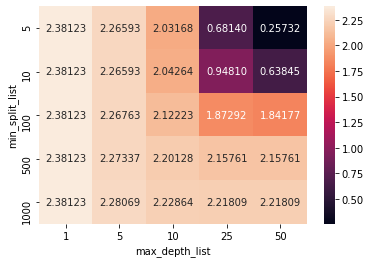


Heatmap for log_loss values CV data


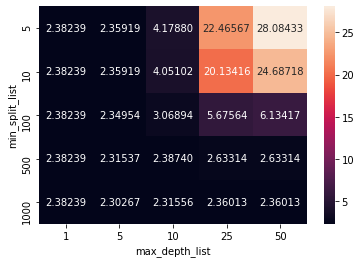


Best Values for Decision Trees

train log_loss for max_depth= 5 ,min_samples_split= 1000 is 2.280690324495666
cv log_loss for max_depth= 5 ,min_samples_split= 1000 is 2.3026686719467886


In [ ]:
#Applying Decision Tree
#Hyper parameter Tuning:

max_depth_list=[1, 5, 10,25, 50]
min_split_list=[5, 10, 100, 500,1000]
log_loss_list_tr = []
log_loss_list_cv = []
for i in min_split_list:
  for j in max_depth_list:
    clf_dt_ev = DecisionTreeClassifier(max_depth=j,min_samples_split=i,random_state=10)
    clf_dt_ev.fit(x_train,y_train)
    y_pred_tr=clf_dt_ev.predict_proba(x_train)
    y_pred_cv=clf_dt_ev.predict_proba(x_cv)
    log_loss_tr_dt=log_loss(y_train,y_pred_tr)
    log_loss_cv_dt=log_loss(y_cv,y_pred_cv)
    log_loss_list_tr.append(log_loss_tr_dt)
    log_loss_list_cv.append(log_loss_cv_dt)


#representing Log_Loss values in HEat Maps
sbn_log_loss_tr=np.reshape(log_loss_list_tr,(5,5))
sbn_log_loss_cv=np.reshape(log_loss_list_cv,(5,5))
import seaborn as sns
xticks=[1,5,10,25,50]
yticks=[5, 10, 100,500,1000]

print('Heatmap for log_loss values Train data')
heat_map_cv = sns.heatmap(sbn_log_loss_tr, annot=True,yticklabels=yticks,xticklabels=xticks,fmt='.5f')
plt.xlabel('max_depth_list')
plt.ylabel('min_split_list')
plt.show()

print('\nHeatmap for log_loss values CV data')
heat_map_cv = sns.heatmap(sbn_log_loss_cv, annot=True,yticklabels=yticks,xticklabels=xticks,fmt='.5f')
plt.xlabel('max_depth_list')
plt.ylabel('min_split_list')
plt.show()


best_max_depth=5
best_min_samples_split=1000

clf_dt_ev = DecisionTreeClassifier(max_depth=best_max_depth,min_samples_split=best_min_samples_split,random_state=10)
clf_dt_ev.fit(x_train,y_train)
y_pred_tr=clf_dt_ev.predict_proba(x_train)
y_pred_cv=clf_dt_ev.predict_proba(x_cv)
log_loss_tr_dt_ev=log_loss(y_train,y_pred_tr)
log_loss_cv_dt_ev=log_loss(y_cv,y_pred_cv)
print('\nBest Values for Decision Trees')
print('\ntrain log_loss for max_depth=',best_max_depth,',min_samples_split=',best_min_samples_split,'is',log_loss_tr_dt_ev)
print('cv log_loss for max_depth=',best_max_depth,',min_samples_split=',best_min_samples_split,'is',log_loss_cv_dt_ev)

#Applying Random Forest Classifier


Heatmap for log_loss values Train data


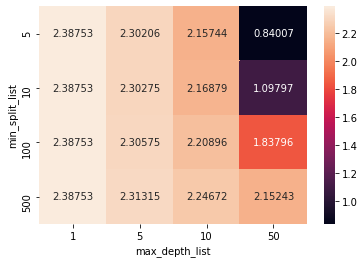


Heatmap for log_loss values Cv data


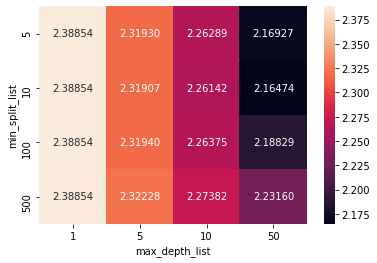

Best Values-Random Forest:

train log_loss for max_depth= 50 ,min_samples_split= 10 is 1.0979733950131434
cv log_loss for max_depth= 50 ,min_samples_split= 10 is 2.1647350644311887


In [ ]:

from sklearn.ensemble import RandomForestClassifier
log_loss_list_tr = []
log_loss_list_cv = []
#Hyper parameter Tuning:

max_depth_list=[1, 5, 10, 50]
min_split_list=[5, 10, 100, 500]
for i in min_split_list:
  for j in max_depth_list:
    clf_rf_ev = RandomForestClassifier(max_depth=j,min_samples_split=i,random_state=10)
    clf_rf_ev.fit(x_train,y_train)
    y_pred_tr=clf_rf_ev.predict_proba(x_train)
    y_pred_cv=clf_rf_ev.predict_proba(x_cv)
    log_loss_tr_rf=log_loss(y_train,y_pred_tr)
    log_loss_cv_rf=log_loss(y_cv,y_pred_cv)
    log_loss_list_tr.append(log_loss_tr_rf)
    log_loss_list_cv.append(log_loss_cv_rf)

#representing Log_Loss values in HEat Maps
sbn_log_loss_tr=np.reshape(log_loss_list_tr,(4,4))
sbn_log_loss_cv=np.reshape(log_loss_list_cv,(4,4))
import seaborn as sns
xticks=[1,5,10,50]
yticks=[5, 10, 100, 500]
print('\nHeatmap for log_loss values Train data')
heat_map_cv = sns.heatmap(sbn_log_loss_tr, annot=True,yticklabels=yticks,xticklabels=xticks,fmt='.5f')
plt.xlabel('max_depth_list')
plt.ylabel('min_split_list')
plt.show()
print('\nHeatmap for log_loss values Cv data')
heat_map_cv = sns.heatmap(sbn_log_loss_cv, annot=True,yticklabels=yticks,xticklabels=xticks,fmt='.5f')
plt.xlabel('max_depth_list')
plt.ylabel('min_split_list')
plt.show()
best_max_depth=50
best_min_samples_split=10

clf_rf_ev = RandomForestClassifier(max_depth=best_max_depth,min_samples_split=best_min_samples_split,random_state=10)
clf_rf_ev.fit(x_train,y_train)
y_pred_tr=clf_rf_ev.predict_proba(x_train)
y_pred_cv=clf_rf_ev.predict_proba(x_cv)
log_loss_tr_rf_ev=log_loss(y_train,y_pred_tr)
log_loss_cv_rf_ev=log_loss(y_cv,y_pred_cv)
print('Best Values-Random Forest:')
print('\ntrain log_loss for max_depth=',best_max_depth,',min_samples_split=',best_min_samples_split,'is',log_loss_tr_rf_ev)
print('cv log_loss for max_depth=',best_max_depth,',min_samples_split=',best_min_samples_split,'is',log_loss_cv_rf_ev)


#Applying LGBM Classifier

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from lightgbm import LGBMClassifier

log_loss_list_tr = []
log_loss_list_cv = []
#Hyper parameter Tuning:
n_est=[10,50,100,350,400,500]
for i in n_est:
    #clf=CatBoostClassifier(n_estimators=i,learning_rate=0.05, colsample_bytree=0.7, max_depth=5,subsample=0.7,objective='multi:softprob',num_class=12,eval_metric='mlogloss')
    clf=LGBMClassifier(verbose=0, n_estimators=i,random_state=10)
    clf.fit(x_train, y_train)
    y_pred_tr=clf.predict_proba(x_train)
    y_pred_cv=clf.predict_proba(x_cv)
    log_loss_tr=log_loss(y_train,y_pred_tr)
    log_loss_cv=log_loss(y_cv,y_pred_cv)
    log_loss_list_tr.append(log_loss_tr)
    log_loss_list_cv.append(log_loss_cv)
    #print('\ntrain log_loss for alpha=',i,'is',log_loss_tr)
    print('cv log_loss for estimator=',i,'is',log_loss_cv)

best_est = n_est[np.argmin(log_loss_list_cv)]

#clf=CatBoostClassifier(n_estimators=i,learning_rate=0.05, colsample_bytree=0.7, max_depth=5,subsample=0.7,objective='multi:softprob',num_class=12,eval_metric='mlogloss')
clf=LGBMClassifier(verbose=0, n_estimators=best_est,random_state=10)
clf.fit(x_train, y_train)
y_pred_tr=clf.predict_proba(x_train)
y_pred_cv=clf.predict_proba(x_cv)
log_loss_tr_lgbm_ev=log_loss(y_train,y_pred_tr)
log_loss_cv_lgbm_ev=log_loss(y_cv,y_pred_cv)
print('Best Values-LGBM Classifier')
print('\n Train log_loss for estimator=',best_est,'is',log_loss_tr_lgbm_ev)
print('cv log_loss for estimator=',best_est,'is',log_loss_cv_lgbm_ev)

cv log_loss for estimator= 10 is 2.2486000640619586
cv log_loss for estimator= 50 is 2.0821114025264444
cv log_loss for estimator= 100 is 2.0308773464290577
cv log_loss for estimator= 350 is 2.0545047119888795
cv log_loss for estimator= 400 is 2.0694064406435486
cv log_loss for estimator= 500 is 2.1063469902403686
Best Values-LGBM Classifier

 Train log_loss for estimator= 100 is 1.275642050075685
cv log_loss for estimator= 100 is 2.0308773464290577


# Applying XGBoost:

In [ ]:
#Applying XGBoost
from xgboost import XGBClassifier
#Hyper parameter Tuning:
n_est=[10,50,100,350,400,500]
log_loss_list_tr = []
log_loss_list_cv = []
for i in n_est:
    clf_xgb_ev=XGBClassifier(n_estimators=i,n_jobs=-1,learning_rate=0.05, colsample_bytree=0.7, max_depth=5,subsample=0.7,objective='multi:softprob',num_class=12,eval_metric='mlogloss')
    clf_xgb_ev.fit(x_train, y_train)
    y_pred_tr=clf_xgb_ev.predict_proba(x_train)
    y_pred_cv=clf_xgb_ev.predict_proba(x_cv)
    log_loss_tr=log_loss(y_train,y_pred_tr)
    log_loss_cv=log_loss(y_cv,y_pred_cv)
    log_loss_list_tr.append(log_loss_tr)
    log_loss_list_cv.append(log_loss_cv)
    print('CV log_loss for estimator=',i,'is',log_loss_cv)

best_estimator = n_est[np.argmin(log_loss_list_cv)]

clf_xgb_ev=XGBClassifier(n_estimators=best_estimator,n_jobs=-1,learning_rate=0.05, colsample_bytree=0.7, max_depth=5,subsample=0.7,objective='multi:softprob',num_class=12,eval_metric='mlogloss')
clf_xgb_ev.fit(x_train, y_train)
y_pred_tr=clf_xgb_ev.predict_proba(x_train)
y_pred_cv=clf_xgb_ev.predict_proba(x_cv)
log_loss_tr_xgb_ev=log_loss(y_train,y_pred_tr)
log_loss_cv_xgb_ev=log_loss(y_cv,y_pred_cv)
print('/nBest Values-XGBoost')
print('\ntrain log_loss for alpha=',best_alpha,'is',log_loss_tr_xgb_ev)
print('cv log_loss for alpha=',best_alpha,'is',log_loss_cv_xgb_ev)




CV log_loss for estimator= 10 is 2.3664308008821755
CV log_loss for estimator= 50 is 2.1847290227779292
CV log_loss for estimator= 100 is 2.1103416782278384
CV log_loss for estimator= 350 is 2.0207619267103842
CV log_loss for estimator= 400 is 2.0157790263853212
CV log_loss for estimator= 500 is 2.0092254981892874
/nBest Values-XGBoost

train log_loss for alpha= 1000 is 1.1579574241689596
cv log_loss for alpha= 1000 is 2.0092254981892874


#Applying CatBoost

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from catboost import CatBoostClassifier
log_loss_list_tr = []
log_loss_list_cv = []
#Hyper parameter Tuning:
n_est=[50,100,500,1000,5000,10000]
for i in n_est:
    clf2=CatBoostClassifier(verbose=0, iterations=i,task_type="GPU")
    clf2.fit(x_train, y_train)
    y_pred_tr=clf2.predict_proba(x_train)
    y_pred_cv=clf2.predict_proba(x_cv)
    log_loss_tr=log_loss(y_train,y_pred_tr)
    log_loss_cv=log_loss(y_cv,y_pred_cv)
    log_loss_list_tr.append(log_loss_tr)
    log_loss_list_cv.append(log_loss_cv)
    #print('\ntrain log_loss for alpha=',i,'is',log_loss_tr)
    print('cv log_loss for estimator=',i,'is',log_loss_cv)

best_est = n_est[np.argmin(log_loss_list_cv)]
clf_cat_ev=CatBoostClassifier(verbose=0, iterations=best_est,task_type="GPU")
clf_cat_ev.fit(x_train, y_train)

y_pred_tr=clf2.predict_proba(x_train)
y_pred_cv=clf2.predict_proba(x_cv)
log_loss_tr_cat_ev=log_loss(y_train,y_pred_tr)
log_loss_cv_cat_ev=log_loss(y_cv,y_pred_cv)
print('\n best values -CatBoost' )
print('\nTrain log_loss for estimator=',best_est,'is',log_loss_tr_cat_ev)
print('CV log_loss for estimator=',best_est,'is',log_loss_cv_cat_ev)

cv log_loss for estimator= 50 is 2.0448126619936575


cv log_loss for estimator= 100 is 2.033606300232809


cv log_loss for estimator= 500 is 2.000260744994612


cv log_loss for estimator= 1000 is 1.9866995252005257


cv log_loss for estimator= 5000 is 1.9757513326122065


cv log_loss for estimator= 10000 is 1.9711458073791572



 best values -CatBoost

Train log_loss for estimator= 10000 is 1.6182983563982503
CV log_loss for estimator= 10000 is 1.9711458073791572


#Applying NN1

In [ ]:
import tensorflow as tf
from keras.callbacks import EarlyStopping,TensorBoard
early_stop_1=EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization,Input,PReLU
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.models import Model
from keras.optimizers import Adagrad
from numpy.random import seed
import tensorflow as tf

def model_1(input_shape):
    model = Sequential()
    model.add(Dense(256, input_dim=input_shape))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(64))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(12))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    return model

nnmodels=10
model_ev_list1=[]
for i in range(nnmodels):
    x_train, x_cv, y_train, y_cv = train_test_split(Xtrain_events, Ytrain_events, test_size=0.15, stratify=Ytrain_events,random_state=5*i)
    y_train_cat=np_utils.to_categorical(y_train)
    y_cv_cat=np_utils.to_categorical(y_cv)
    model=model_1(x_train.shape[1])
    model.fit(x_train, y_train_cat, batch_size=1000, epochs=25, verbose=0, validation_data=(x_cv, y_cv_cat),callbacks=[early_stop_1])
    model_ev_list1.append(model)
x_train, x_cv, y_train, y_cv = train_test_split(Xtrain_events, Ytrain_events, test_size=0.15, stratify=Ytrain_events,random_state=10)
y_pred_nn_tr=np.zeros((x_train.shape[0],12))
y_pred_nn_cv=np.zeros((x_cv.shape[0],12))

for i in range(nnmodels):
  y_pred_nn_tr=y_pred_nn_tr+model_ev_list1[i].predict_proba(x_train)
  y_pred_nn_cv=y_pred_nn_cv+model_ev_list1[i].predict_proba(x_cv)
y_pred_nn_tr=y_pred_nn_tr/nnmodels
y_pred_nn_cv=y_pred_nn_cv/nnmodels

log_loss_tr_nn1_ev=log_loss(y_train,y_pred_nn_tr)
log_loss_cv_nn1_ev=log_loss(y_cv,y_pred_nn_cv)


print('\nNeural Network1:')
print("\nTrain Log-Loss: ",log_loss_tr_nn1_ev)
print("CV Log-Loss: ",log_loss_cv_nn1_ev )



Neural Network1:

Train Log-Loss:  1.455256971434226
CV Log-Loss:  1.5385117433148292


#Applying Neural Network2

In [ ]:
import tensorflow as tf
from keras.callbacks import EarlyStopping,TensorBoard
early_stop_1=EarlyStopping(monitor='val_loss',patience=4,restore_best_weights=True)
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization,Input,PReLU
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.models import Model
from keras.optimizers import Adagrad


def model_2(input_dim,output_dim, learRate=0.0025):
    model = Sequential()
    model.add(Dense(512, input_shape=(input_dim,)))
    model.add(PReLU())
    model.add(Dropout(0.5))
    model.add(Dense(output_dim))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

nnmodels=20
model_ev_list2=[]
avg_cv_loss=0
for i in range(nnmodels):
    x_train, x_cv, y_train, y_cv = train_test_split(Xtrain_events, Ytrain_events, test_size=0.15, stratify=Ytrain_events,random_state=5*i)
    y_train_cat=np_utils.to_categorical(y_train)
    y_cv_cat=np_utils.to_categorical(y_cv)
    model=model_2(x_train.shape[1],12)
    model.fit(x_train, y_train_cat, batch_size=500, epochs=100, verbose=0, validation_data=(x_cv, y_cv_cat),callbacks=[early_stop_1])
    model_ev_list2.append(model)
    
nnmodels=20
x_train, x_cv, y_train, y_cv = train_test_split(Xtrain_events, Ytrain_events, test_size=0.15, stratify=Ytrain_events,random_state=5*i)
y_pred_nn_tr=np.zeros((x_train.shape[0],12))
y_pred_nn_cv=np.zeros((x_cv.shape[0],12))
for i in range(nnmodels):
  y_pred_nn_tr=y_pred_nn_tr+model_ev_list2[i].predict_proba(x_train)
  y_pred_nn_cv=y_pred_nn_cv+model_ev_list2[i].predict_proba(x_cv)
y_pred_nn_tr=y_pred_nn_tr/nnmodels
y_pred_nn_cv=y_pred_nn_cv/nnmodels

log_loss_tr_nn2_ev=log_loss(y_train,y_pred_nn_tr)
log_loss_cv_nn2_ev=log_loss(y_cv,y_pred_nn_cv)

print('\nNeural Network2:')
print("\nTrain Log-Loss: ",log_loss_tr_nn2_ev)
print("CV Log-Loss: ",log_loss_cv_nn2_ev)


Neural Network2:

Train Log-Loss:  1.5942675110089934
CV Log-Loss:  1.6185869759655205


#Pretty Table-Events:

In [ ]:
log_loss_cv_lr_ev=1.9935984109023066
log_loss_cv_dt_ev=2.3026686719467886
log_loss_cv_rf_ev=2.1647350644311887
log_loss_cv_lgbm_ev=2.0308773464290577
log_loss_cv_xgb_ev=2.0092254981892874
log_loss_cv_cat_ev=1.9711458073791572
log_loss_cv_nn1_ev=1.5385117433148292
log_loss_cv_nn2_ev=1.6185869759655205


In [ ]:
from prettytable import PrettyTable
pt = PrettyTable()

pt.field_names = ["Models for No events Data", " CV Log-loss"]
pt.add_row(["Logistic Regression",  log_loss_cv_lr_ev])
pt.add_row(["Decision Tree",   log_loss_cv_dt_ev])
pt.add_row(["Random Forest Classifier",  log_loss_cv_rf_ev ])
pt.add_row(["LGBM Classifier",  log_loss_cv_lgbm_ev])
pt.add_row(["XGBoost", log_loss_cv_xgb_ev])
pt.add_row(["CatBoost", log_loss_cv_cat_ev])
pt.add_row(["Avg Neural Network1",  log_loss_cv_nn1_ev])
pt.add_row(["Avg Neural Network2", log_loss_cv_nn2_ev])

print(pt)

+---------------------------+--------------------+
| Models for No events Data |     CV Log-loss    |
+---------------------------+--------------------+
|    Logistic Regression    | 1.9935984109023066 |
|       Decision Tree       | 2.3026686719467886 |
|  Random Forest Classifier | 2.1647350644311887 |
|      LGBM Classifier      | 2.0308773464290577 |
|          XGBoost          | 2.0092254981892874 |
|          CatBoost         | 1.9711458073791572 |
|    Avg Neural Network1    | 1.5385117433148292 |
|    Avg Neural Network2    | 1.6185869759655205 |
+---------------------------+--------------------+


Observation:
CatBoost ,Avg NN1 & Avg NN2 models can be used for best results

#Applying Best Models on Test Data

In [ ]:
#Loading data
datadir = '/content/drive/MyDrive/Talkingdata_CS1/talkingdata-mobile-user-demographics/data/'
gender_age_test = pd.read_csv(os.path.join(datadir,'gender_age_test.csv'))
events_data = pd.read_csv(os.path.join(datadir,'events.csv'),parse_dates=['timestamp'], index_col='event_id')
device_id_has_events=events_data.device_id.unique() 
gender_age_test['has_events']=gender_age_test.device_id.apply(lambda x:1 if x in device_id_has_events else 0)  
gatest_has_events=gender_age_test.loc[gender_age_test['has_events']==1].drop(['has_events'],axis=1).set_index('device_id')
gatest_has_noevents=gender_age_test.loc[gender_age_test['has_events']==0].drop(['has_events'],axis=1).set_index('device_id')

gender_age_train = pd.read_csv(os.path.join(datadir,'gender_age_train.csv'),index_col='device_id')
from sklearn.preprocessing import LabelEncoder
y_encoder_ev=LabelEncoder().fit(gender_age_train.group)

Predicting X_test data with Noevents:

In [ ]:
#using Avg NN1 model
y_pred_nn1_noev=np.zeros((Xtest_noevents.shape[0], 12))
for i in range(20):
  y_pred_nn1_noev=y_pred_nn1_noev+model_noev_list1[i].predict_proba(Xtest_noevents)
y_pred_nn1_noev=y_pred_nn1_noev/20

In [ ]:
#using Avg NN2 model
y_pred_nn2_noev=np.zeros((Xtest_noevents.shape[0], 12))
for i in range(10):
  y_pred_nn2_noev=y_pred_nn2_noev+model_noev_list2[i].predict_proba(Xtest_noevents)
y_pred_nn2_noev=y_pred_nn2_noev/10

In [ ]:
#Ensemble model1:
w1=0.4
w2=0.4
w3=0.2
Ytest_noevents_pred=w2*y_pred_nn1_noev +w1*clf_cat_noev.predict_proba(Xtest_noevents)+w3*y_pred_nn2_noev

Predicting X_test with Events:

In [ ]:
#using Avg NN1 model
y_pred_nn1_ev=np.zeros((Xtest_events.shape[0], 12))
for i in range(10):
  y_pred_nn1_ev=y_pred_nn1_ev+model_ev_list1[i].predict_proba(Xtest_events)
y_pred_nn1_ev=y_pred_nn1_ev/10

In [ ]:
#using Avg NN2 model
y_pred_nn2_ev=np.zeros((Xtest_events.shape[0], 12))
for i in range(20):
  y_pred_nn2_ev=y_pred_nn2_ev+model_ev_list2[i].predict_proba(Xtest_events)
y_pred_nn2_ev=y_pred_nn2_ev/20

In [ ]:
#Ensemble model2:
w1=0.1
w2=0.1
w3=0.8
Ytest_events_pred=w2*y_pred_nn1_ev +w1*clf_cat_ev.predict_proba(Xtest_events)+w3*y_pred_nn2_ev

Concatenating test data results

In [ ]:
y_pred1 = pd.DataFrame(Ytest_noevents_pred, index = gatest_has_noevents.index, columns=y_encoder_ev.classes_)
y_pred2 = pd.DataFrame(Ytest_events_pred, index = gatest_has_events.index, columns=y_encoder_ev.classes_)
y_test_pred=pd.concat([y_pred1,y_pred2])
y_test_pred.head()

,F23-,F24-26,F27-28,F29-32,F33-42,F43+,M22-,M23-26,M27-28,M29-31,M32-38,M39+
device_id,,,,,,,,,,,,
-5893464122623104785,0.041228,0.062194,0.041664,0.061885,0.056237,0.042204,0.079203,0.162216,0.097387,0.109660,0.144822,0.101301
-7560708697029818408,0.041228,0.062194,0.041664,0.061885,0.056237,0.042204,0.079203,0.162216,0.097387,0.109660,0.144822,0.101301
289797889702373958,0.056765,0.056009,0.042473,0.065415,0.084100,0.066051,0.090660,0.118225,0.071856,0.100017,0.129854,0.118575
-402874006399730161,0.056765,0.056009,0.042473,0.065415,0.084100,0.066051,0.090660,0.118225,0.071856,0.100017,0.129854,0.118575
5751283639860028129,0.050808,0.062147,0.042489,0.067749,0.083947,0.069963,0.074460,0.126007,0.076857,0.097849,0.142111,0.105613


In [ ]:
#saving test data predicted
y_test_pred.to_csv('/content/sample_data/pred_files15')

#Score


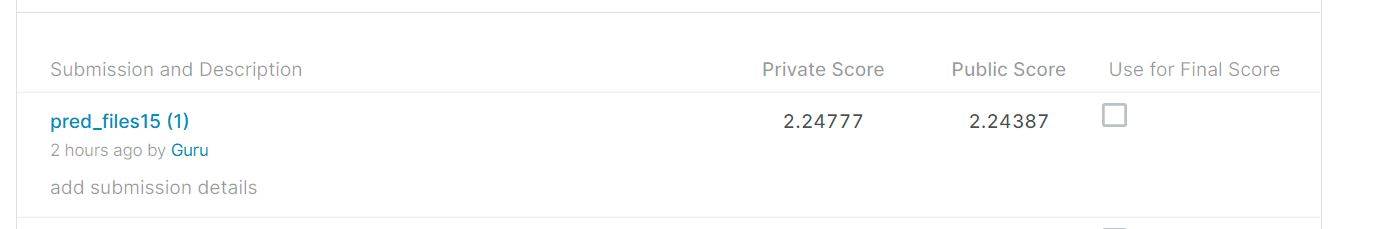

In [ ]:
from IPython.display import Image
Image(filename=('/content/score.JPG'))


# Rank~240